# [BERTによる類似文書の検索](https://lab.m-field.co.jp/2020/11/30/search-by-bert/)

## 下準備

In [ ]:
%%bash
# データセットのダウンロード
wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
tar xvzf ldcc-20140209.tar.gz
# ライブラリのインストール
apt install aptitude swig
aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
#pip install mecab-python3==0.996.5
pip install mecab-python3
#pip install unidic-lite nlplot japanize-matplotlib transformers fugashi ipadic
pip install unidic-lite japanize-matplotlib transformers fugashi ipadic
#pip install nlplot==1.2.0

text/
text/CHANGES.txt
text/dokujo-tsushin/
text/it-life-hack/
text/kaden-channel/
text/livedoor-homme/
text/movie-enter/
text/peachy/
text/README.txt
text/smax/
text/sports-watch/
text/topic-news/
text/topic-news/LICENSE.txt
text/topic-news/topic-news-5903225.txt
text/topic-news/topic-news-5903373.txt
text/topic-news/topic-news-5907376.txt
text/topic-news/topic-news-5908396.txt
text/topic-news/topic-news-5910461.txt
text/topic-news/topic-news-5910462.txt
text/topic-news/topic-news-5911453.txt
text/topic-news/topic-news-5913367.txt
text/topic-news/topic-news-5913447.txt
text/topic-news/topic-news-5914835.txt
text/topic-news/topic-news-5918064.txt
text/topic-news/topic-news-5921231.txt
text/topic-news/topic-news-5927166.txt
text/topic-news/topic-news-5927208.txt
text/topic-news/topic-news-5927215.txt
text/topic-news/topic-news-5927968.txt
text/topic-news/topic-news-5928611.txt
text/topic-news/topic-news-5930156.txt
text/topic-news/topic-news-5930399.txt
text/topic-news/topic-news-593112

--2021-07-16 01:51:21--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  270K 32s
    50K .......... .......... .......... .......... ..........  1%  563K 23s
   100K .......... .......... .......... .......... ..........  1%  560K 21s
   150K .......... .......... .......... .......... ..........  2%  159M 15s
   200K .......... .......... .......... .......... ..........  2%  564K 15s
   250K .......... .......... .......... .......... ..........  3%  182M 13s
   300K .......... .......... .......... .......... ..........  4%  151M 11s
   350K .......... .......... .......... .......... ..........  4%  566K 11s
   400K .......... .......... ..

In [ ]:
%%bash
pip install pandas numpy tqdm seaborn matplotlib wordcloud pillow networkx ipython scikit-learn
pip install plotly>=4.12.0 -U
pip install pyLDAvis==2.1.2
pip install nlplot==1.2.0

In [ ]:
#!pip install --upgrade plotly

     |████████████████████████████████| 20.6MB 9.6MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
#!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6MB 7.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=da16efe4cb1786428d11e9b13dd11904c68007065f67393200391bdb73fdc5c9
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
  Found existing installation: pyLDAvis 3.3.1
    Uninstalling pyLDAvis-3.3.1:
      Successfully uninstalled pyLDAvis-3.3.1


## データセットの読み込み

In [ ]:
import pkg_resources, imp
imp.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import nlplot
import warnings
warnings.simplefilter('ignore')    
import torch
import transformers
from transformers import BertJapaneseTokenizer
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR) # tokenize時の警告を抑制
def load_dataset():
    """データセットの読み込み"""
    paths = []
    for dirpath, dirnames, filenames in os.walk('./text'):
        for file in filenames:
            if re.match(r'.+[0-9].txt',  file):
                #print("{0}".format(file))
                paths.append(os.path.join(dirpath, file))                
    data = {
        'path': [],
        'URL': [],
        'date': [],
        'title': [],
        'text': [],
    }
    for path in paths:
        with open(path, 'r') as f:
            url = f.readline().strip('¥n')
            date = f.readline().strip('¥n')
            title = f.readline().strip('¥n')
            text = f.read()
            data['path'].append(path)
            data['URL'].append(url)
            data['date'].append(date)
            data['title'].append(title)
            data['text'].append(text)
    return pd.DataFrame(data)
df = load_dataset()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



## 文書の特徴ベクトル化

In [ ]:
#!pip install transformers==3.0.0

In [ ]:
class BertExtractor:
    """文書特徴抽出用クラス"""
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' #GPUが使用可能ならGPUを使用
        self.model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking' #使用する学習済みモデル名
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(self.model_name) #使用するBERTトークナイザー
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name) #学習済みモデル呼び出し
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128 #使用する入力文書の長さ。最大512まで
    
    def extract(self, sentence):
        """文書特徴ベクトルを抽出する"""
        # 文書のトークナイズ
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)
        # 入力トークン数の調整
        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
        # モデルへ文書を入力し特徴ベクトルを取り出す
        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)        
        seq_out, _ = self.bert_model(inputs_tensor, return_dict=False)
        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [ ]:
def cos_sim_matrix(matrix):
    """文書間のコサイン類似度を計算し、類似度行列を返す"""
    d = matrix @ matrix.T
    norm = (matrix * matrix).sum(axis=1, keepdims=True) ** .5
    return d / norm / norm.T

In [ ]:
bex = BertExtractor()
df['text_feature'] = df['text'].progress_apply(lambda x: bex.extract(x)) # 文書の特徴ベクトル化
sim = cos_sim_matrix(np.stack(df.text_feature)) # 類似度行列

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 類似文書の検索

In [ ]:
def search(n=100):
    doc = df.sample(1)
    doc_idx = doc.index[0]
    sim_index = sim[doc_idx].argsort()[::-1]
    rec_df = df.iloc[sim_index][:n]
    rec_df['similarity'] = np.sort(sim[doc_idx])[::-1][:n]
    return rec_df[['title', 'text', 'similarity']]

df2 = search()

## 検索結果の可視化

In [ ]:
def tokenize(text,):
    tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
    wakati_ids = tokenizer.encode(text, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(wakati_ids[0].tolist())
    return tokens[1:-1] #[CLS], [SEP]トークンを除く

df2['tokenized_text'] = df2['text'].progress_apply(tokenize)

In [ ]:
npt = nlplot.NLPlot(df2, target_col='tokenized_text')

# top_nで頻出上位単語, min_freqで頻出下位単語を指定できる
stopwords = npt.get_stopword(top_n=20, min_freq=0)

In [ ]:
# bi-gram表示
npt.bar_ngram(
    title='bi-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=2,
    top_n=50,
    stopwords=stopwords,
)

100%|██████████| 100/100 [00:00<00:00, 3205.28it/s]


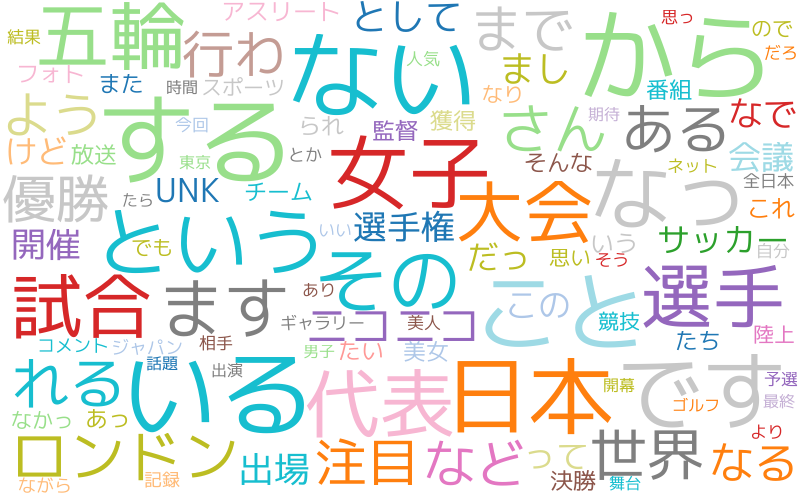

In [ ]:
npt.wordcloud(
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
    stopwords=stopwords,
)

# [自然言語を簡単に可視化・分析できるライブラリ「nlplot」を公開しました](https://www.takapy.work/entry/2020/05/17/192947)

## N-gram bar chart

In [ ]:
# 1. N-gram bar chart
npt.bar_ngram(title='uni-gram', ngram=1, top_n=50, stopwords=stopwords)

100%|██████████| 100/100 [00:00<00:00, 2427.32it/s]


In [ ]:
npt.bar_ngram(title='bi-gram', ngram=2, top_n=50, stopwords=stopwords)

100%|██████████| 100/100 [00:00<00:00, 2471.16it/s]


## N-gram tree Map

In [ ]:
# 2. N-gram tree Map
npt.treemap(title='Tree of Most Common Words', ngram=1, top_n=30, stopwords=stopwords)

100%|██████████| 100/100 [00:00<00:00, 2950.85it/s]


## Histogram of the word count

In [ ]:
# 3. Histogram of the word count
npt.word_distribution(title='words distribution')

## wordcloud

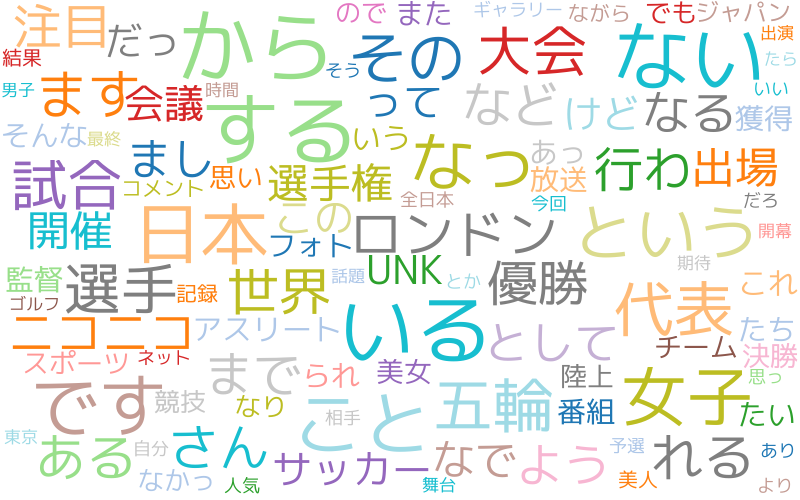

In [ ]:
# 4. wordcloud
npt.wordcloud(stopwords=stopwords, colormap='tab20_r')

## co-occurrence networks

In [ ]:
# 5. co-occurrence networks
npt.build_graph(stopwords=stopwords, min_edge_frequency=10)

# The number of nodes and edges to which this output is plotted.
# If this number is too large, plotting will take a long time, so adjust the [min_edge_frequency] well.
# >> node_size:70, edge_size:166
npt.co_network(title='Co-occurrence network')

node_size:305, edge_size:7005


## sunburst chart

In [ ]:
# 6. sunburst chart
npt.sunburst(title='sunburst chart', colorscale=True)

## pyLDAvis

In [ ]:
# 7. pyLDAvis
# If you want to run it in a notebook environment, you need to use the import and magic commands
import pyLDAvis
pyLDAvis.enable_notebook()
npt.ldavis(num_topics=5, passes=5, save=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.014837 -0.013330       1        1  49.299331
0     -0.060183 -0.024810       2        1  25.265397
2     -0.025500  0.003760       3        1  11.661714
3      0.079599 -0.039441       4        1   7.475730
4      0.020921  0.073820       5        1   6.297828, topic_info=    Term         Freq        Total Category  logprob  loglift
21     、  1881.000000  1881.000000  Default  30.0000  30.0000
37     に   903.000000   903.000000  Default  29.0000  29.0000
39     の  1438.000000  1438.000000  Default  28.0000  28.0000
22     。   990.000000   990.000000  Default  27.0000  27.0000
26     が   774.000000   774.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
169   いる     8.312865   152.718702   Topic5  -5.7741  -0.1458
292   日本     7.796206   114.116778   Topic5  -5.8382   0.0814
164    「    10.070330   517.360519   Topic5  -5.5823  -1.1742
165    」     9.272718   472.400518   Topic5  -5.6648  -1.1658
173    さ     6.875708   146.729659   Topic5  -5.9639  -0.2956

[382 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2943      1  0.965909    "
1897      1  0.369266  ##)
1897      3  0.615443  ##)
4260      1  0.954325  ##-
4260      2  0.011361  ##-
...     ...       ...  ...
5454      5  0.448992    音
2378      1  0.158141   音楽
2378      3  0.790706   音楽
4258      4  0.659508   飲酒
4495      2  0.910813    鼻

[549 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5])